# Chapter 2: Teaching Our Agent to Read 📚

In the previous chapter, we built a simple QA agent that relied solely on its pre-trained knowledge. While impressive, it had a significant limitation - it couldn't access or understand your personal documents and files. It's like having a brilliant friend who can tell you everything about world history but can't read the document right in front of them!


In this chapter, we'll fix that by teaching our agent to read and understand document files. We'll also dive deep into fascinating concepts like context windows and explore the delicate balance between context size and speed. Let's get started! 🚀

## Setup

First, let's import the `OpenAILLM` class that we coded in the previous chapter

In [2]:
from pctopus.llm.openai_llm import OpenAILLM

## Initialize the LLM
llm = OpenAILLM()

##  Teaching Our Agent to Use Context 🎓

Let's start by creating a function that helps our agent use additional context when answering questions. By default, we'll have the agent use `gpt-3.5-turbo` model from OpenAI.

In [3]:
from typing import Optional

def ask_llm_with_context(context: str, question: str, system_instruction: Optional[str] = None, model: str = "gpt-3.5-turbo") -> str:
    """Ask a question with specific context"""

    question_with_context = f"""
        Context: {context} 
        Question: {question}
        """
    
    response = llm.ask(
        prompt=question_with_context,
        system_message=system_instruction,
        model=model
    )
    return response

#### Let's try it with a simple example where we give the LLM some context about me (Suhas), and ask it questions based on the context provided. In the system instruction, we ask the LLM to say "I cannot find the answer in the provided context" if the question asked can't be answered with the provided context. 

In [4]:
system_instruction = """
Use the provided context to answer the question. 
If you cannot find the answer from the provided context, say "I cannot find the answer in the provided context."
"""

context = """
Suhas was born in Bangalore, India. 
He did his undergraduate studies in Aerospace Engineering at IIT Madras in Chennai, India. 
He came to the United States for his masters in Computational and Applied Mathematics at Stanford Univeristy. 
He currently works at Adobe as a Senior Machine Learning Engineer in the Search, Discovery and Content AI team. 
"""

questions = [
    "Where was Suhas born?",
    "Where did he complete his masters from?",
    "Where does Suhas work now?",  
    "How many countries has Suhas visited?", # Not in context
    "How many languages does Suhas know?" # Not in context
]


print ("Testing our context-aware QA agent:")
for question in questions:
    print(f"\nQ: {question}")
    print(f"A: {ask_llm_with_context(context, question, system_instruction)}")

Testing our context-aware QA agent:

Q: Where was Suhas born?
A: Suhas was born in Bangalore, India.

Q: Where did he complete his masters from?
A: Stanford University

Q: Where does Suhas work now?
A: Suhas currently works at Adobe as a Senior Machine Learning Engineer in the Search, Discovery, and Content AI team.

Q: How many countries has Suhas visited?
A: I cannot find the answer in the provided context.

Q: How many languages does Suhas know?
A: I cannot find the answer in the provided context.


Great! Our agent can now:

- ✅ Use provided context to answer questions
- ✅ Admit when it can't find information in the context
- ✅ Stick to the facts from the context

## Reading from Documents  📄

Now that our agent can use context, let's teach it to read text content from actual documents:

In [5]:
import os 
from pathlib import Path

## This function is used to read from text files
def read_txt_file(file_path: str) -> str:
    """Read content from a text file"""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except UnicodeDecodeError:
        # Fallback encodings if UTF-8 fails
        for encoding in ['latin-1', 'ascii', 'utf-16']:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    return file.read()
            except UnicodeDecodeError:
                continue
        raise

## This function is used to read the text content from PDF files
def read_pdf_file(file_path: str) -> str:
    """Read content from a PDF file"""
    try:
        from PyPDF2 import PdfReader
        reader = PdfReader(file_path)
        return '\n'.join(page.extract_text() for page in reader.pages)
    except ImportError:
        raise ImportError("PyPDF2 is required to read PDF files. Install it using: pip install PyPDF2")

## This function is used to read the text content from Word document (.doc, .docx)
def read_word_file(file_path: str) -> str:
    """Read content from a Word document"""
    try:
        from docx import Document
        doc = Document(file_path)
        return '\n'.join(paragraph.text for paragraph in doc.paragraphs)
    except ImportError:
        raise ImportError("python-docx is required to read Word files. Install it using: pip install python-docx")

## A common class that we can use to extract text content from text files, PDFs and Word document
class DocumentReader:
    def __init__(self):
        # Register file formats and their corresponding reader functions
        self.readers: Dict[str, Callable] = {
            '.txt': read_txt_file,
            '.pdf': read_pdf_file,
            '.doc': read_word_file,
            '.docx': read_word_file,
        }

    def supported_formats(self) -> list[str]:
        """Return list of supported file formats"""
        return list(self.readers.keys())

    def read_document(self, file_path: str) -> str:
        """
        Read content from a document file based on its extension
        
        Args:
            file_path (str): Path to the document file
            
        Returns:
            str: Text content of the document
            
        Raises:
            ValueError: If the file format is not supported
            FileNotFoundError: If the file doesn't exist
        """
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        file_extension = Path(file_path).suffix.lower()
        
        reader = self.readers.get(file_extension)
        if reader is None:
            supported = ', '.join(self.supported_formats())
            raise ValueError(f"Unsupported file format: {file_extension}. Supported formats are: {supported}")
            
        return reader(file_path)

##### We'll feed the entire context from the document to the LLM agent using the `ask_llm_with_context` function that we wrote above. 

In [6]:
doc_reader = DocumentReader()

def ask_llm_from_document(file_path: str, question: str, system_instruction: Optional[str] = None, model: str = "gpt-3.5-turbo") -> str:
    """Ask a question using text content from a document file as context."""
    document_text_content = doc_reader.read_document(file_path)
    return ask_llm_with_context(document_text_content, question, system_instruction, model)

### Let's now test it with my LinkedIn profile, which is saved as a PDF

This PDF is located at `documents/suhas_suresha_linkedin_profile.pdf`

In [8]:
suhas_linkedin_text = doc_reader.read_document("documents/suhas_suresha_linkedin_profile.pdf")
print (suhas_linkedin_text[:100])

   
Contact
www.linkedin.com/in/suhas-
suresha  (LinkedIn)
Top Skills
Time-Series Prediction
Generat


In [9]:
def count_words(text: str) -> int:
    """
    Count the number of words in a string.
    """
    # Remove extra whitespace and split into words
    words = text.strip().split()
    return len(words)

print (f"Number of words in Suhas's LinkedIn profile = {count_words(suhas_linkedin_text)}")

Number of words in Suhas's LinkedIn profile = 617


#### Let's now ask questions based on this PDF

In [10]:
system_instruction = """
Use the provided context to answer the question. 
If you cannot find the answer from the provided context, say "I cannot find the answer in the provided context."
"""

document_path = "documents/suhas_suresha_linkedin_profile.pdf"

questions = [
    "Where was Suhas born?", ## not in the pdf
    "Where did he complete his masters from?",
    "Where does Suhas work now?",  
    "How many countries has Suhas visited?", # Not in the pdf
    "How many languages does Suhas know?" 
]

for question in questions:
    print(f"\nQ: {question}")
    print(f"A: {ask_llm_from_document(document_path, question, system_instruction)}")


Q: Where was Suhas born?
A: I cannot find the answer in the provided context.

Q: Where did he complete his masters from?
A: Stanford University.

Q: Where does Suhas work now?
A: Suhas currently works at Adobe as a Senior Machine Learning Engineer.

Q: How many countries has Suhas visited?
A: I cannot find the answer in the provided context.

Q: How many languages does Suhas know?
A: Suhas knows four languages: English, Kannada, Hindi, and Tamil.


### Okay that worked quite well! 🎉

### Let's try something more ambitious now. We'll feed the entire text of "The Great Gatsby" novel, which has 51,257 words, into our agent.  

This file is located at `documents/the_great_gatsby.txt`

In [11]:
gatsby_text = doc_reader.read_document("documents/the_great_gatsby.txt")
print (f"Number of words in The Great Gatsby novel = {count_words(gatsby_text)}")

Number of words in The Great Gatsby novel = 51257


In [12]:
system_instruction = """
Use the provided context to answer the question. 
If you cannot find the answer from the provided context, say "I cannot find the answer in the provided context."
"""

document_path = "documents/the_great_gatsby.txt"

question = "What does Gatsby's real name turn out to be, and why did he change it?"
answer = ask_llm_from_document(document_path, question, system_instruction)

print(f"\nQ: {question}")
print(f"A: {answer}")

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 69572 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

### Uh-oh! Seems like our agent has hit a wall! 🤖💥

If you look at the error message, it says `This model's maximum context length is 16385 tokens. However, your messages resulted in 69576 tokens. Please reduce the length of the messages.` Let's dive deeper into why this happened. 

## The Great Token Mystery: Understanding Tokens and Context Windows 🔍

### What are Tokens? 

If you remember, we breifly introduced **tokens** in Chapter 1 as the **building blocks of language that the LLM processes**. Let's revisit this concept now. 

Think of tokens as the LLM's **"thought chunks"** - they're the bite-sized pieces it uses to process text. Just like how we humans break down sentences into words, LLMs break down text into tokens. However, tokens don't map one-to-one with words - they can be:

- Common single words ("the", "and")
- Parts of words ("ing", "ed", "pre")
- Characters (especially for uncommon words)
- Special characters and spaces

This flexible tokenization helps the model be more efficient. For example, common words like "the", "and" or "beautiful" might be single tokens because they appear so frequently. Meanwhile, rare words like "discombobulated" might be split into several tokens ("dis", "comb", "ob", "ulated").

For example, let's see how a simple sentence gets broken down into tokens:

In [13]:
import tiktoken

def show_tokenization(text: str, model: str = "gpt-3.5-turbo") -> None:
    """Show how text gets split into tokens"""
    encoding = tiktoken.encoding_for_model(model)
    tokens = encoding.encode(text)
    
    # Decode each token individually to see the splits
    token_texts = [encoding.decode_single_token_bytes(token).decode('utf-8', errors='replace') for token in tokens]
    
    print(f"Text: {text}")
    print(f"Token count: {len(tokens)}")
    print("Tokens:", token_texts)

# Let's try some examples
examples = [
    "Hello, world!", # Common phrase
    "thank you very much",  # Common phrase
    "discombobulated",  # Uncommon word
]

for text in examples:
    print("\n" + "="*50)
    show_tokenization(text)


Text: Hello, world!
Token count: 4
Tokens: ['Hello', ',', ' world', '!']

Text: thank you very much
Token count: 4
Tokens: ['thank', ' you', ' very', ' much']

Text: discombobulated
Token count: 4
Tokens: ['dis', 'comb', 'ob', 'ulated']


### Different Models, Different Tokenizers 🔄

Each LLM family typically comes with its own tokenizer - the tool that breaks text into tokens. This means the same text might be split very differently depending on which model you're using:


#### GPT-2 Tokenizer ("gpt2")
- Basic tokenization approach
- Vocabulary size: ~50k tokens
- Primarily focused on English text

#### GPT-3.5/GPT-4 Tokenizer ("cl100k_base")
- Optimized for modern internet text
- Strong handling of code and technical content
- Vocabulary size: ~100k tokens
- Improved efficiency in token usage

#### GPT-4o Optimized Tokenizer ("o200k_base")
- Significantly larger vocabulary (~200k tokens)
- Enhanced multilingual support
- More efficient tokenization for non-English words
- Particularly improved performance for:
  - Russian
  - Korean
  - Vietnamese
  - Chinese
  - Japanese
  - Turkish

These differences matter because:

1. The same text will use different numbers of tokens in different models
2. Cost calculations vary (since you pay per token)
3. Context window limits affect different amounts of text
4. Some models handle certain content types better

Let's see these differences in action:

In [14]:
import tiktoken
import pandas as pd
from typing import Dict

def compare_tokenizers(text: str) -> Dict[str, int]:
    """Compare how different tokenizers process the same text."""
    # Define models with different tokenizers
    models = {
        "GPT-2": "gpt2",
        "GPT-3.5-turbo": "gpt-3.5-turbo", 
    }
    
    # Count tokens for each model
    results = {}
    for name, model in models.items():
        encoding = tiktoken.encoding_for_model(model)
        tokens = encoding.encode(text)
        results[name] = len(tokens)
        
        # Show the actual tokens for analysis
        token_texts = [encoding.decode_single_token_bytes(token).decode('utf-8', errors='replace') for token in tokens]
        print(f"\n{name} tokenization of '{text}':")
        print(f"Token count: {len(tokens)}")
        print("Tokens:", token_texts)
        
    return results

# Test cases demonstrating key differences
test_cases = {
    "Common Phrase": "thank you",
    "Non-English": "こんにちは",  # Japanese
    "Code": """
    for i in range(1, 6):
        for j in range(1, 6):
            result = i * j
            print(f"{result:3}", end="")
        print()  # This creates a new line after each row
    """
}

print("🔍 Comparing different tokenizers:")
print("=" * 50)

# Run comparison for each test case
for case_name, text in test_cases.items():
    print(f"\n📝 Test case: {case_name}")
    results = compare_tokenizers(text)
    
    # Show token count differences
    df = pd.DataFrame([results]).T
    df.columns = ['Token Count']
    print("\nToken count comparison:")
    print(df)
    print("=" * 50)

🔍 Comparing different tokenizers:

📝 Test case: Common Phrase

GPT-2 tokenization of 'thank you':
Token count: 2
Tokens: ['thank', ' you']

GPT-3.5-turbo tokenization of 'thank you':
Token count: 2
Tokens: ['thank', ' you']

Token count comparison:
               Token Count
GPT-2                    2
GPT-3.5-turbo            2

📝 Test case: Non-English

GPT-2 tokenization of 'こんにちは':
Token count: 6
Tokens: ['こ', 'ん', 'に', '�', '�', 'は']

GPT-3.5-turbo tokenization of 'こんにちは':
Token count: 1
Tokens: ['こんにちは']

Token count comparison:
               Token Count
GPT-2                    6
GPT-3.5-turbo            1

📝 Test case: Code

GPT-2 tokenization of '
    for i in range(1, 6):
        for j in range(1, 6):
            result = i * j
            print(f"{result:3}", end="")
        print()  # This creates a new line after each row
    ':
Token count: 97
Tokens: ['\n', ' ', ' ', ' ', ' for', ' i', ' in', ' range', '(', '1', ',', ' 6', '):', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '

#### We see that the tokenizer for `GPT-3.5-turbo` model reduces the number of tokens needed for non-english text and python code when copmapred to `GPT-2`. 

### Context Windows: The LLM's Working Memory 🪟

The context window is like the LLM's working memory - it's the maximum amount of tokens that the model can "think about" at once. This includes:

- The system message (instructions we give)
- The context (like our document text)
- The user's question
- The LLM's response

Different models have different context window sizes:

| Model | Context Window | 
|:--|:--|
| GPT-3.5-Turbo | 16,385 tokens |
| GPT-4o-mini | 128,000 tokens | 
| GPT-4o | 128,000 tokens |


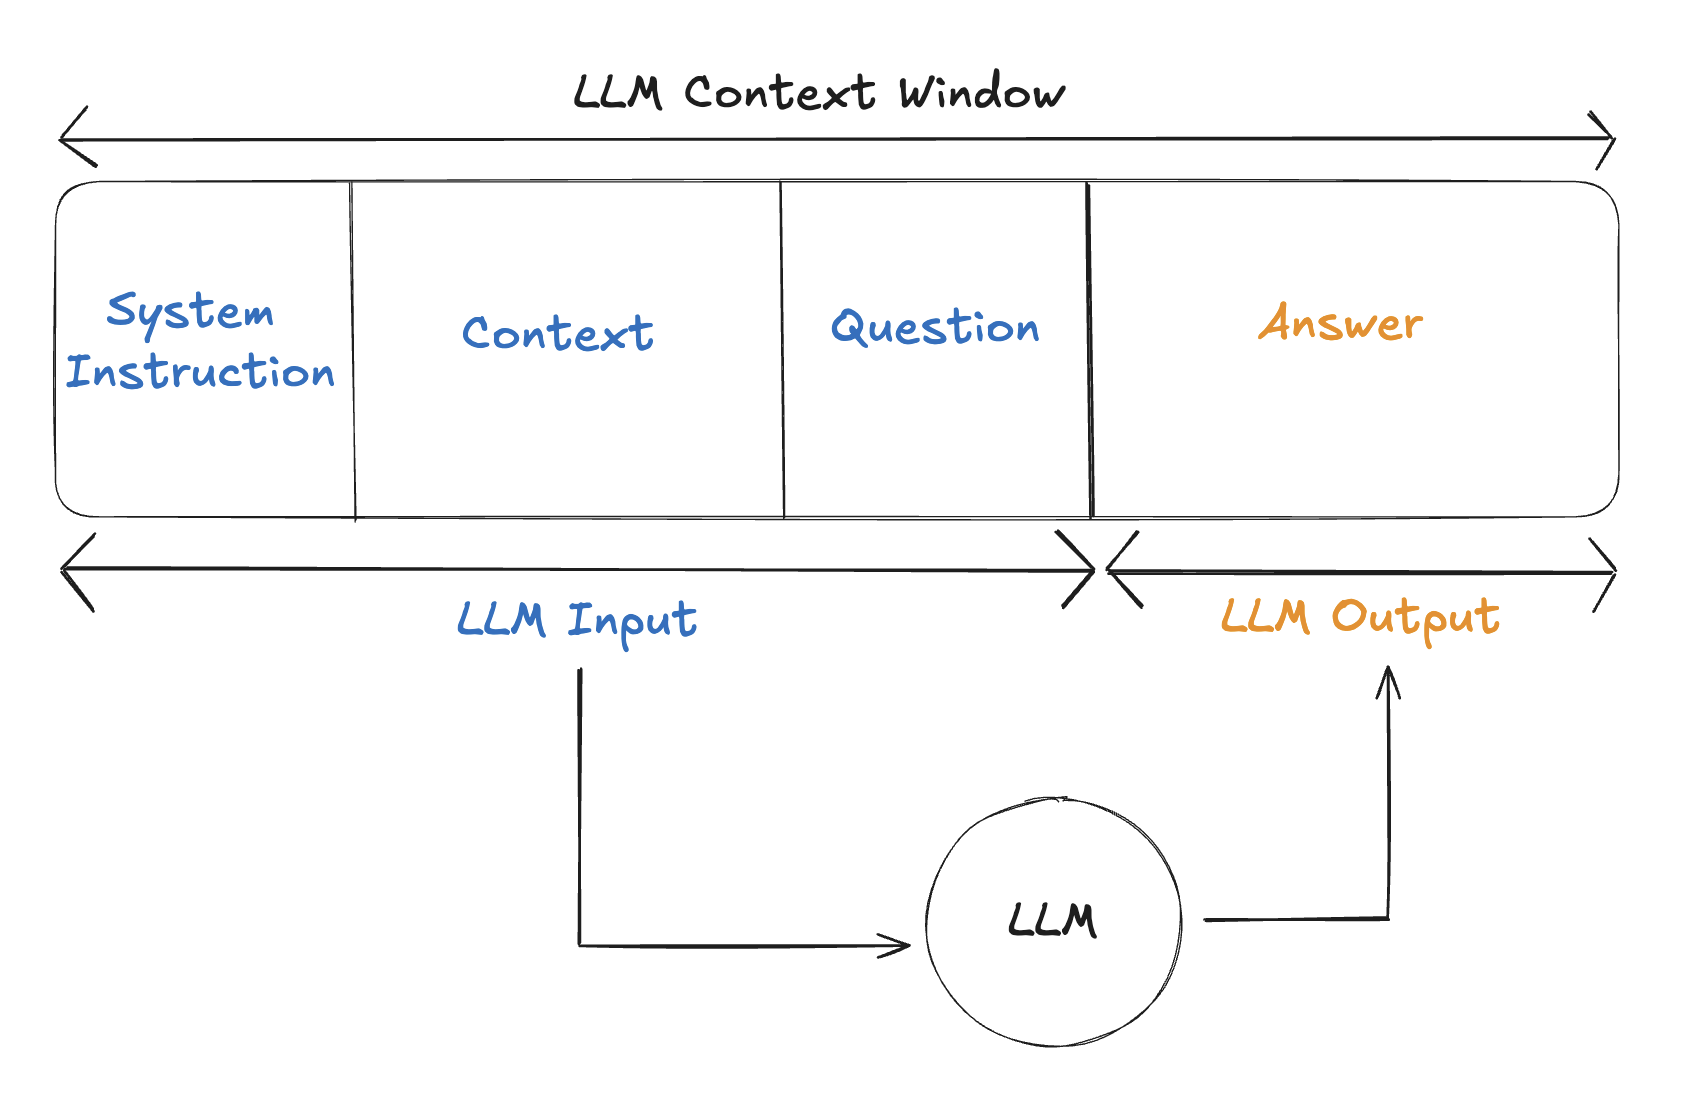

## Understanding Why The Great Gatsby Example Failed 🔍

Remember how our attempt to analyze The Great Gatsby failed with an error about exceeding the context window? Now that we understand tokens and context windows, let's break down exactly what happened.

Let's calculate the tokens we were trying to use:

In [15]:
def count_tokens(text: str, model: str = "gpt-3.5-turbo") -> int:
    """Count tokens for a given text using specified model's tokenizer"""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

gatsby_text = doc_reader.read_document("documents/the_great_gatsby.txt")
gatsby_tokens = count_tokens(gatsby_text)

print(f"Tokens in the Great Gatsby text: {gatsby_tokens:,} tokens")

Tokens in the Great Gatsby text: 69,499 tokens


#### Remember, `GPT-3.5-turbo` has a context window of **16,385 tokens**. Just The Great Gatsby alone uses about **69,499 tokens!** That's not even including the tokens needed for system instructions and the user question. That's why we got the error message. It's like trying to fit an entire novel into a small notepad.

### Let's Fix It: Using GPT-4o-mini 🛠️

GPT-4o-mini has a much larger context window of **128,000 tokens**. Let's modify our code to use it instead:

In [16]:
system_instruction = """
Use the provided context to answer the question. 
If you cannot find the answer from the provided context, say "I cannot find the answer in the provided context."
"""

document_path = "documents/the_great_gatsby.txt"

question = "What does Gatsby's real name turn out to be, and why did he change it?"
answer = ask_llm_from_document(document_path, question, system_instruction, model='gpt-4o-mini')

print(f"\nQ: {question}")
print(f"A: {answer}")


Q: What does Gatsby's real name turn out to be, and why did he change it?
A: Gatsby's real name is James Gatz. He changed it to Jay Gatsby at the age of seventeen when he met Dan Cody, who was a wealthy yacht owner. Gatsby adopted the name as part of his aspiration to reinvent himself and align with his dreams of wealth and success, distancing himself from his humble beginnings.


## The Cost of Large Contexts: Measuring Latency 📊

You might have noticed that running the previous code might have taken some time before you got a response back. That's because typically, **the more context we feed into an LLM, the longer it takes to process.** 

Let's measure the response time of an LLM for different text length to prove this:

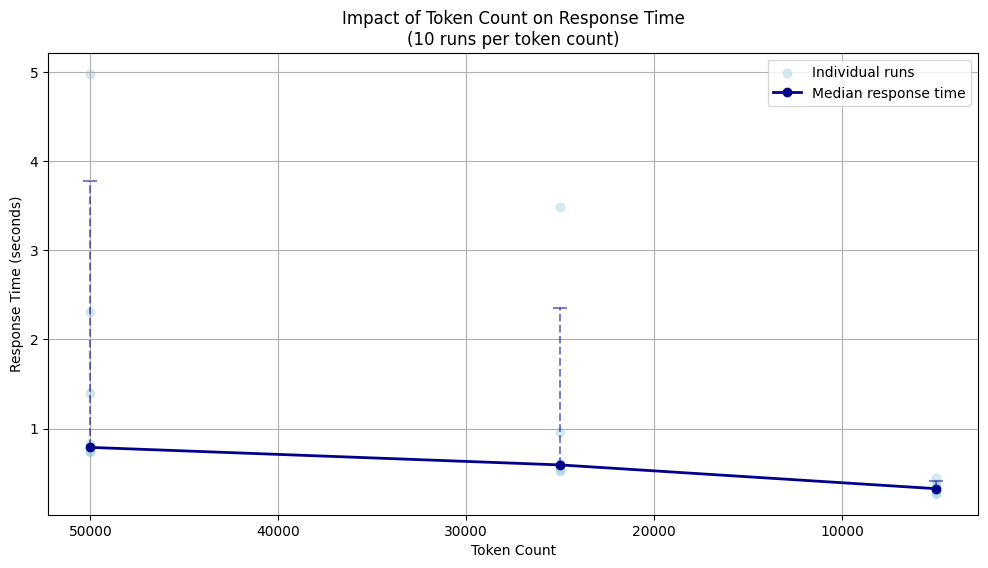


Statistical Summary:

Token Count: 50000
Median Response Time: 0.79 seconds
95th Percentile: 3.78 seconds
Min Time: 0.74 seconds
Max Time: 4.98 seconds

Token Count: 25000
Median Response Time: 0.59 seconds
95th Percentile: 2.35 seconds
Min Time: 0.53 seconds
Max Time: 3.49 seconds

Token Count: 5000
Median Response Time: 0.32 seconds
95th Percentile: 0.42 seconds
Min Time: 0.27 seconds
Max Time: 0.45 seconds


In [16]:
import time
import tiktoken
import matplotlib.pyplot as plt
import numpy as np

def generate_text_with_token_count(target_token_count: int) -> str:
    """Generate text with approximately the specified number of tokens"""
    tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")
    base_text = "This is a sample text for testing language model response times."
    base_tokens = len(tokenizer.encode(base_text))
    
    repetitions = target_token_count // base_tokens
    context = base_text * repetitions
    
    current_tokens = len(tokenizer.encode(context))
    while current_tokens < target_token_count:
        context += "Additional text. "
        current_tokens = len(tokenizer.encode(context))
    
    return context

def measure_response_time(token_count: int, model: str) -> float:
    """Measure response time for different token counts"""
    context = generate_text_with_token_count(token_count)
    
    start_time = time.time()
    response = ask_llm_with_context(
        system_instruction="Just return the word ok, and nothing else.",
        context=context,
        question="",
        model=model
    )
    end_time = time.time()
    
    return end_time - start_time

# Test different token counts with multiple runs
token_counts = [50000, 25000, 5000]
num_runs = 10
all_response_times = []  # Store all runs for each token count

for count in token_counts:
    run_times = []
    for _ in range(num_runs):
        time_4 = measure_response_time(count, "gpt-4o-mini")
        run_times.append(time_4)
    all_response_times.append(run_times)

# Calculate medians and p95
median_response_times = [np.median(times) for times in all_response_times]
p95_response_times = [np.percentile(times, 95) for times in all_response_times]

# Create visualization
plt.figure(figsize=(12, 6))

# Plot individual runs
for i, times in enumerate(all_response_times):
    plt.scatter([token_counts[i]] * num_runs, times, 
                alpha=0.5, color='lightblue', 
                label='Individual runs' if i == 0 else "")

# Plot medians with a line
plt.plot(token_counts, median_response_times, 
         marker='o', color='darkblue', linewidth=2, 
         label='Median response time')

# Add p95 "error" bars (showing range up to p95)
for i, (count, median, p95) in enumerate(zip(token_counts, median_response_times, p95_response_times)):
    plt.vlines(count, median, p95, color='darkblue', linestyle='--', alpha=0.5)
    plt.scatter([count], [p95], color='darkblue', alpha=0.5, marker='_', s=100)

# Customize the plot
plt.xlabel('Token Count')
plt.ylabel('Response Time (seconds)')
plt.title('Impact of Token Count on Response Time\n(10 runs per token count)')
plt.legend()
plt.grid(True)

# Reverse x-axis to show larger token counts on the left
plt.gca().invert_xaxis()

plt.show()

# Print statistical summary
print("\nStatistical Summary:")
for i, count in enumerate(token_counts):
    times = all_response_times[i]
    print(f"\nToken Count: {count}")
    print(f"Median Response Time: {np.median(times):.2f} seconds")
    print(f"95th Percentile: {np.percentile(times, 95):.2f} seconds")
    print(f"Min Time: {np.min(times):.2f} seconds")
    print(f"Max Time: {np.max(times):.2f} seconds")

#### As you can see from the graph, there's a clear correlation between context size and response time. Typically, the larger the context, the longer we have to wait for an answer from the LLM. 

## Problems with Our Current Approach 🤔

Our current approach of feeding entire documents into the context window faces several critical challenges:

### 1. Context Window Limitations
- **Size Restrictions**: As we saw with The Great Gatsby example, many documents exceed model context window limits
- **Multi-Document Problems**: Can't combine multiple documents if their total size exceeds the context window
- **Cost Inefficiency**: Paying for maximum token usage even when only a small portion of the document is relevant

### 2. Performance and Latency Issues
- **Response Time Degradation**: As we demonstrated in our latency tests, larger contexts lead to slower responses
- **Resource Intensity**: Processing large documents requires more computational resources
- **User Experience Impact**: Long wait times can make the system impractical for real-world use

### 3. Relevance and Precision Issues

When we feed entire documents into the context window, we face several challenges with answer quality:

1. **Information Dilution**: The LLM has to sift through a lot of irrelevant text to find the answer
2. **Answer Reliability**: With so much context, the model might blend information from different parts and the resulting answer may not be very reliable 


#### Let's demonstrate how irrelevant context affects LLM's performance using a simple example:

In [17]:
import random

def generate_noisy_context(fact, num_words_before=1000, num_words_after=1000):
    # List of random words to choose from (you can expand this list)
    word_bank = [
        "apple", "banana", "computer", "dog", "elephant", "flower", "guitar",
        "house", "internet", "jacket", "kitchen", "laptop", "mountain", "notebook",
        "orange", "pencil", "quiet", "river", "sunshine", "table", "umbrella",
        "violin", "window", "xylophone", "yellow", "zebra", "book", "car", "desk",
        "cup", "phone", "tree", "cloud", "bird", "chair", "door", "fish", "grass"
    ]
    
    # Generate random text before the fact
    before_text = " ".join(random.choice(word_bank) for _ in range(num_words_before))
    
    # Generate random text after the fact
    after_text = " ".join(random.choice(word_bank) for _ in range(num_words_after))
    
    # Combine all parts
    noisy_context = f"""
    Here's a long text about various topics:
    {before_text} {fact} {after_text}
    """
    return noisy_context

#### In this example, we hide the actual fact in a noisy context (with 1000 random words before and after) and see how the LLM performs as opposed to providing just the fact without all the noise. 

In [18]:
system_instruction = """
Use the provided context to answer the question. 
If you cannot find the answer from the provided context, say "I cannot find the answer in the provided context."
"""

clean_context = "Suhas was born in Bangalore, India."
noisy_context = generate_noisy_context(clean_context)

## Compare responses
question = "Where was Suhas born?"
answer_with_clean_context = ask_llm_with_context(clean_context, question, system_instruction, model="gpt-3.5-turbo")
answer_with_noisy_context = ask_llm_with_context(noisy_context, question, system_instruction, model="gpt-3.5-turbo")

print (f"Response with clean context: {answer_with_clean_context}")
print (f"Response with noisy context: {answer_with_noisy_context}")

Response with clean context: Suhas was born in Bangalore, India.
Response with noisy context: I cannot find the answer in the provided context.


#### Interestingly, we see that the LLM fails to answer the question for the noisy context example even when the fact is included in the context window. This demonstrates one of the issues with feeding large contexts to a LLM. 

## Looking Ahead: Retrieval-Augmented Generation (RAG) 🚀

In the next chapter, we'll solve these problems by introducing a smarter way to handle documents:

Instead of feeding entire documents to the LLM, we'll:
1. **First find the relevant information** from our documents
2. **Then ask the LLM questions** using just that **relevant context** as opposed to feeding in entire documents

To achieve this, we'll explore different search techniques:
- Simple text-based search (like keyword matching)
- Semantic search using embeddings
- Hybrid approaches that combine multiple search methods

This approach, known as **Retrieval-Augmented Generation (RAG)**, will help us overcome the limitations we discussed and build a more efficient document QA system.

## Let's end this chapter with a practical implementation - a Gradio interface for document QA

In [19]:
import gradio as gr
from pathlib import Path
import tempfile
import shutil


def qa_from_file(file_obj, question, system_instruction, model_name):
    """Answer questions based on uploaded file content"""
    if file_obj is None:
        return "Please upload a file first."
    
    try:
        # Use our existing function with the file path Gradio provides
        response = ask_llm_from_document(
            file_path=file_obj.name, 
            question=question,
            system_instruction=system_instruction,
            model=model_name
        )
        return response
        
    except Exception as e:
        return f"Error: {str(e)}"

with gr.Blocks() as demo:
    gr.Markdown("# Document Q&A System")
    
    with gr.Row():
        with gr.Column():
            file_input = gr.File(label="Upload Document")
            model_dropdown = gr.Dropdown(
                choices=["gpt-3.5-turbo", "gpt-4o-mini"],
                value="gpt-3.5-turbo",
                label="Select Model"
            )
            system_input = gr.Textbox(
                label="System Instruction",
                value="Use the provided context to answer the question. If you cannot find the answer from the provided context, say 'I cannot find the answer in the provided context.'"
            )
            question_input = gr.Textbox(label="Your Question")
            submit_btn = gr.Button("Get Answer")
        
        with gr.Column():
            output = gr.Textbox(label="Answer")
    
    # Handle file submission
    submit_btn.click(
        qa_from_file,
        inputs=[file_input, question_input, system_input, model_dropdown],
        outputs=output
    )


demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
